In [261]:
#importing all required modules and necessary libraries/packages
import pandas as pd # data processsing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

#visualizing the data
import seaborn as sns  # for plot styling
import matplotlib.pyplot as plt # for plotting

#allows chart to appear in the notebook
%matplotlib inline

# Data Selection

In [262]:
#importing all the datasets
Clinical = pd.read_csv('data_clinical.csv', sep=',')
Counts = pd.read_csv('data_counts_normalized.csv', sep=',')
#HLA = pd.read_csv('data_hla_alleles.csv', sep=',')
#Neoantigens = pd.read_csv('data_neoantigens.csv', sep=',')
#Signatures = pd.read_csv('data_signatures.csv', sep=',')
TCR = pd.read_csv('data_tcr.csv', sep=',')
#TCR_expansionAB = pd.read_csv('data_tcr_expansion_a_b.csv', sep=',')
#TCR_expansionAC = pd.read_csv('data_tcr_expansion_a_c.csv', sep=',')
#Variants = pd.read_csv('data_variants.csv', sep=',')

In [263]:
#Take a look at the dataset before pre-processing to get a sense of what the data looks like
#Clinical.head(30)
#Clinical.info()
#TCR.isnull().sum()

# Data Pre-processing

In [264]:
#Set new variable
ClinPat_ID = set(Clinical['patient_id'])

In [265]:
# Load TCRs, restricting to time point A peripheral samples
#extract 
pbmc_TCR = TCR.loc[(TCR['Sample Type'] == 'PBMC') & (TCR['Time Point'] == 'A') & (TCR['patient_id'].isin(ClinPat_ID))]
tumor_TCR = TCR.loc[(TCR['Sample Type'] == 'Tumor') & (TCR['Time Point'] == 'A') & (TCR['patient_id'].isin(ClinPat_ID))]
#pbmc_TCR.head()
#tumor_TCR.info()

In [275]:
# Extract columns we want from each dataset
##Clinical Dataset
new_Clinical = Clinical.iloc[:, np.r_[1:4,5,13,23,32,55:58]]
# (1) change Y/N in 'Prior BCG' column from the Clinical dataset to 1/0
# creating a dict file  
bcg = {'Y': 1,'N': 0} 
# traversing through dataframe 'Prior BCG' column and writing values where key matches 
new_Clinical.loc[:,['Prior BCG']] = [bcg[item] for item in new_Clinical['Prior BCG']]
new_Clinical.head()

,5-factor score,Age,Albumin < 4,Baseline neutrophil to lymphocyte ratio,Number of chemo regimens total,Prior BCG,Time since last chemotherapy,patient_id,pfs,progressed
0,3.0,71,0,2.22,3,1,87.0,40,20,True
1,1.0,68,0,4.25,1,0,416.0,471,61,True
2,2.0,46,0,4.37,1,1,231.0,522,58,True
3,3.0,66,0,4.22,2,0,78.0,1233,398,True
4,4.0,78,0,1.53,1,0,26.0,1249,41,True


NameError: name 'progressed' is not defined

In [208]:
# (2) change 'True' to 1, and 'False' to 0 (from the progression column)
progression = {'True': 1,'False': 0} 
new_Clinical.loc[:,['progressed']] = [progression[item] for item in new_Clinical['progressed']]
#print(Clinical.columns.values)
new_Clinical.head(25)
#new_Clinical.info()

KeyError: True

In [ ]:
#for i in new_Clinical.loc[:,['Best response mRECIST']]:
#    if i == cr_pr:
#       new_Clinical.loc[:,['Best response mRECIST']] = 1
#  else:
#     new_Clinical.loc[:,['Best response mRECIST']] = 0



In [276]:
##Tumor and PBMC(circulating) dataset
new_tumor_TCR = tumor_TCR.iloc[:, np.r_[0,8:11]]
new_pbmc_TCR = pbmc_TCR.iloc[:, np.r_[0,8:12,13]]


In [277]:
#Merging all the datasets together
from functools import reduce
DataFrames =[new_Clinical,Counts,new_pbmc_TCR,new_tumor_TCR]
DataMerge = reduce(lambda  left,right: pd.merge(left,right,on=['patient_id'], how='outer'), DataFrames)


In [278]:
DataMerge.head()
#DataMerge.info()
#DataMerge.isnull().sum()

,5-factor score,Age,Albumin < 4,Baseline neutrophil to lymphocyte ratio,Number of chemo regimens total,Prior BCG,Time since last chemotherapy,patient_id,pfs,progressed,...,neoantigen_count,expressed_neoantigen_count,T-cell fraction_x,Clonality_x,Diversity_x,Productive Unique TCRs (cnt),Top Clone Freq(%),T-cell fraction_y,Clonality_y,Diversity_y
0,3.0,71,0,2.22,3,1,87.0,40,20,True,...,20.217559,5.297257,30.673962,0.149980,13.998695,90690,8.838484,0.0128,0.063967,7.742366
1,1.0,68,0,4.25,1,0,416.0,471,61,True,...,9.939782,2.949992,41.107861,0.348957,10.497178,71400,15.266910,0.0666,0.115946,8.408900
2,2.0,46,0,4.37,1,1,231.0,522,58,True,...,1.334525,0.222421,37.317482,0.081610,15.592970,129142,3.052312,NaN,NaN,NaN
3,3.0,66,0,4.22,2,0,78.0,1233,398,True,...,0.075335,0.000000,39.053012,0.047118,16.449041,157219,0.935107,0.2171,0.128326,10.373350
4,4.0,78,0,1.53,1,0,26.0,1249,41,True,...,11.464085,0.349752,46.631985,0.219364,13.171150,119971,11.407323,0.0363,0.221381,7.624849


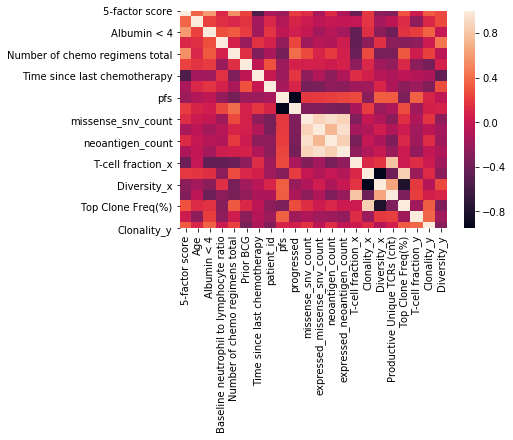

In [279]:
#Preprocessing data
sns.heatmap(DataMerge.corr())

In [281]:
Final_dataset = DataMerge.dropna()
#Final_dataset.isnull().sum()

5-factor score                             0
Age                                        0
Albumin < 4                                0
Baseline neutrophil to lymphocyte ratio    0
Number of chemo regimens total             0
Prior BCG                                  0
Time since last chemotherapy               0
patient_id                                 0
pfs                                        0
progressed                                 0
missense_snv_count                         0
expressed_missense_snv_count               0
neoantigen_count                           0
expressed_neoantigen_count                 0
T-cell fraction_x                          0
Clonality_x                                0
Diversity_x                                0
Productive Unique TCRs (cnt)               0
Top Clone Freq(%)                          0
T-cell fraction_y                          0
Clonality_y                                0
Diversity_y                                0
dtype: int

In [284]:
#Extract output/Clinical Results column before continuing with data pre-processing
progressedResults = Final_dataset['progressed']
#progressedResults.head(25)

0      True
1      True
3      True
4      True
5      True
6      True
7     False
8     False
10     True
11     True
12     True
13    False
14    False
15     True
16     True
17     True
19     True
20     True
21     True
22     True
23     True
24     True
Name: progressed, dtype: bool

In [152]:
#find correlation between all the features
#Final_dataset.head()
#Final_dataset.patient_id
#sns.heatmap(Final_dataset.corr())

In [285]:
#delete the 'patientID' and 'progressed' columns
Final_dataset = Final_dataset.drop(['patient_id','progressed'], axis=1)
#print(Final_dataset.columns)

In [286]:
#Final_dataset.head()
Final_dataset.info()
#print(Final_dataset.isnull().sum())
#print(Final_dataset.columns.values)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 24
Data columns (total 20 columns):
5-factor score                             22 non-null float64
Age                                        22 non-null int64
Albumin < 4                                22 non-null int64
Baseline neutrophil to lymphocyte ratio    22 non-null float64
Number of chemo regimens total             22 non-null int64
Prior BCG                                  22 non-null int64
Time since last chemotherapy               22 non-null float64
pfs                                        22 non-null int64
missense_snv_count                         22 non-null float64
expressed_missense_snv_count               22 non-null float64
neoantigen_count                           22 non-null float64
expressed_neoantigen_count                 22 non-null float64
T-cell fraction_x                          22 non-null float64
Clonality_x                                22 non-null float64
Diversity_x              

In [154]:
# change all values of type 'float' to 'int'
#cols = ['5-factor score','Baseline neutrophil to lymphocyte ratio','Time since last chemotherapy','missense_snv_count','expressed_missense_snv_count',
#       'neoantigen_count','expressed_neoantigen_count','T-cell fraction_x','Clonality_x','Diversity_x','Top Clone Freq(%)',
#       'T-cell fraction_y','Clonality_y','Diversity_y']
#print(cols.columns.v)

In [249]:
#Final_dataset[cols] = Final_dataset[cols].applymap(np.int64)
Final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 24
Data columns (total 20 columns):
5-factor score                             22 non-null float64
Age                                        22 non-null int64
Albumin < 4                                22 non-null int64
Baseline neutrophil to lymphocyte ratio    22 non-null float64
Number of chemo regimens total             22 non-null int64
Prior BCG                                  22 non-null int64
Time since last chemotherapy               22 non-null float64
pfs                                        22 non-null int64
missense_snv_count                         22 non-null float64
expressed_missense_snv_count               22 non-null float64
neoantigen_count                           22 non-null float64
expressed_neoantigen_count                 22 non-null float64
T-cell fraction_x                          22 non-null float64
Clonality_x                                22 non-null float64
Diversity_x              

In [305]:
# look at Final data and prep it before running Kmeans
X = Final_dataset
X = X.infer_objects()
X = X.astype('int')
#X.head()

In [247]:
# Eliminating null values
for i in X.columns:
    X[i].fillna(int(X[i].mean()))
for i in X.columns:
    print(X[i].isnull().sum())
#X.info()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

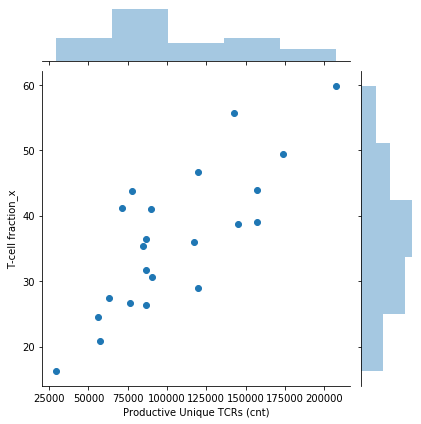

In [260]:
#sns.heatmap(Final_dataset.corr())
sns.jointplot('Productive Unique TCRs (cnt)','T-cell fraction_x',data=Final_dataset)

# Data Transformation

## Feature Selection/Reduction

In [ ]:
#preprocesing/data transformation modules
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold

#### (1) Kmeans Clustering

In [222]:
#find feature similarity and reduce noise
# 1st approach 'kmeans clustering'

#Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(Final_dataset)
    wcss.append(kmeans.inertia_)

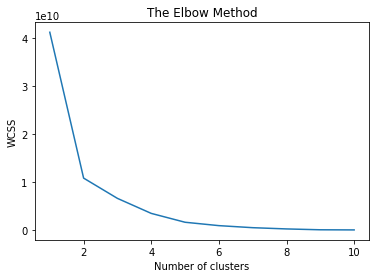

In [223]:
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [244]:
#Applying k-means to the dataset
kmeans = KMeans(n_clusters=2, init='k-means++',max_iter=300, n_init=10,random_state=0)
y_kmeans = kmeans.fit_predict(X)
#print(X)
X.dtype
#Xdf = X.values()


dtype('int64')

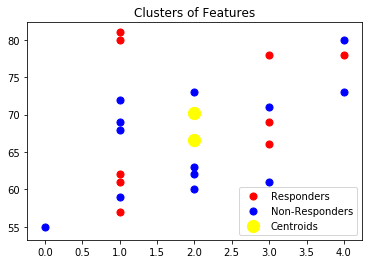

In [235]:
plt.scatter(X[y_kmeans == 0,0], X[y_kmeans == 0,1], s=50,c='red',label='Responders')
plt.scatter(X[y_kmeans == 1,0], X[y_kmeans == 1,1], s=50,c='blue',label='Non-Responders')
#plt.scatter(X[y_kmeans == 2,0], X[y_kmeans == 2,1], s=100,c='green',label='Non-Responders')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=150,c='yellow',label='Centroids')
plt.title('Clusters of Features')
plt.legend()
plt.show()

In [ ]:
#old sklearn stuff (see youtube video)
#from sklearn.metrics import pairwise_distances_argmin
#def find_clusters(X, n_clusters, rseed=2)

#### (2) Feature Reduction by PCA Analysis

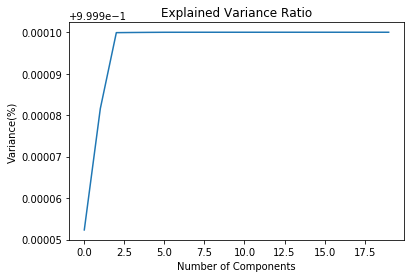

In [254]:
from sklearn import decomposition
from sklearn.decomposition import PCA

# determine the number of components
# pass through scaled data set
pca = PCA().fit(X)
# plot the cummulative sumation of the explained variance
#plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Variance(%)')
plt.show()

In [347]:
pcaCLF = make_pipeline(StandardScaler(),
                   PCA(n_components=2, random_state=0))

In [349]:
pcaModel = pcaCLF.fit(X_train, y_train)

In [348]:
# Use a nearest neighbor classifier to evaluate the methods
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

In [354]:
 # Fit a nearest neighbor classifier on the embedded training set
knn.fit(pcaModel.transform(X_train), y_train)

# Compute the nearest neighbor accuracy on the embedded test set
acc_knn = knn.score(pcaModel.transform(X_test), y_test)

# Embed the data set in 2 dimensions using the fitted model
X_embedded = pcaModel.transform(X)

ValueError: Unknown format code 'f' for object of type 'str'

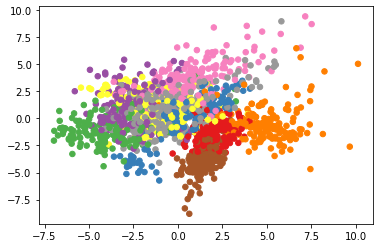

In [355]:
# Plot the projected points and show the evaluation score
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap='Set1')
plt.title("KNN Test accuracy = {:.2f}".format(name, n_neighbors, acc_knn))

In [255]:
# run PCA analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_


array([9.99952328e-01, 2.92530344e-05])

In [256]:
#store in a new data set
pca_dataset = pd.DataFrame(data = X_pca, columns =['PCA1','PCA2'])
pca_dataset.head()

,PCA1,PCA2
0,-13742.163896,-102.056324
1,-33032.257865,160.423546
2,52787.363811,-181.267072
3,15538.865101,-131.057690
4,12744.065998,41.121993


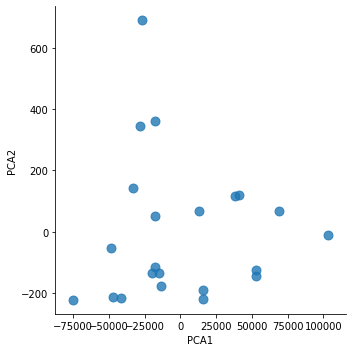

In [140]:
#plot PCA results
#sns.lmplot('PC1','PC2',data=pca_dataset)
#plt.tite('PCA result')

sns.lmplot(x="PCA1",y="PCA2",data=pca_dataset, 
  fit_reg=False, 
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

#### (3) Feature Dimension reduction by LDA

In [258]:
from sklearn import discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X)

TypeError: fit() missing 1 required positional argument: 'y'

In [73]:
import sklearn
print('The sklearn version is {}.'.format(sklearn.__version__))

The sklearn version is 0.20.3.


In [291]:
#Separating the Target variable
X = Final_dataset
y = progressedResults

In [322]:
#Spliting Dataset into Test set and Train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

### Train the model

In [329]:
#Function to perform training with Data
#import svm (machine learning model) that we will be using
from sklearn import svm
from sklearn.svm import SVC
#create a svm classifier
svmCLF = svm.SVC(kernel='linear', C=1000) #linear kernel
#train the model on training dataset
svmCLF.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

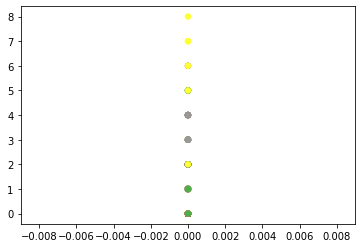

In [361]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
plt.show()

In [314]:
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svmModel.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
           alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(svmModel.support_vectors_[:, 0],
           svmModel.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key

### Test the model

In [330]:
#test the model / predict response on test dataset (to evaluate prediction)
y_predSVM = svmCLF.predict(X_test)

In [331]:
print(y_predSVM)

[ True False  True  True  True  True  True]


In [332]:
# look at output (predictions) values
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predSVM))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test,y_predSVM))

Accuracy: 0.8571428571428571
Precision: 0.8333333333333334
              precision    recall  f1-score   support

       False       1.00      0.50      0.67         2
        True       0.83      1.00      0.91         5

    accuracy                           0.86         7
   macro avg       0.92      0.75      0.79         7
weighted avg       0.88      0.86      0.84         7



In [ ]:
# Model classification full report
# extract report to determine how good the model is
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predSVM))


# Try different Models
Random Forest; 
Gradient Boosting Machine; 
Convoluted Neural Network.

## (1) Logistic Regression

In [299]:
from sklearn.linear_model import LogisticRegression
logModel = LogisticRegression()
logModel.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [302]:
y_pred = logModel.predict(X_test)

In [303]:
print(y_pred)

[ True False  True  True  True  True  True  True  True]


In [333]:
# extract report to determine how good the model is
from sklearn.metrics import classification_report
#print(classification_report(y_test, y_pred))

## (2) Gradient Boosting Model

In [334]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
gbmCLF = GradientBoostingClassifier()
gbmCLF.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [335]:
y_predGBM = gbmCLF.predict(X_test)
print(y_predGBM)

[ True False  True False  True  True  True]


In [336]:
# extract report to determine how good the model is
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predGBM))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00         2
        True       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [337]:
print("gbm model Accuracy:",metrics.accuracy_score(y_test, y_predGBM))
print("gbm model Precision:",metrics.precision_score(y_test,y_predGBM))

gbm model Accuracy: 1.0
gbm model Precision: 1.0


In [338]:
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_predGBM)

NameError: name 'roc_curve' is not defined

In [346]:
from sklearn import datasets
# Load Digits dataset
digits = DataFrames)datasets.load_digits

TypeError: 'list' object is not callable